# rrexpress - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 34 # rrexpress
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(3637, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637 entries, 0 to 3636
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            3637 non-null   int64  
 1   dimCustomerMasterId     3637 non-null   int64  
 2   customerNumber          3637 non-null   object 
 3   year                    3637 non-null   int64  
 4   productGrouping         3637 non-null   object 
 5   totalSpent              3637 non-null   float64
 6   recentDate              3637 non-null   object 
 7   attendancePercent       3637 non-null   float64
 8   renewedBeforeDays       3637 non-null   int64  
 9   isBuyer                 3637 non-null   object 
 10  source_tenure           3637 non-null   int64  
 11  tenure                  3637 non-null   int64  
 12  distToVenue             3637 non-null   float64
 13  totalGames              3637 non-null   int64  
 14  recency                 3637 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
        "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2325, 16)
Unseen Data For Predictions: (410, 16)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7617,0.8285,0.8269,0.7814,0.8028,0.5019,0.5049,0.3000
xgboost,Extreme Gradient Boosting,0.7546,0.8188,0.8217,0.7753,0.7971,0.4868,0.4897,0.2970


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7576,0.8558,0.8103,0.7833,0.7966,0.4968,0.4973
1,0.6919,0.7796,0.7845,0.7165,0.7490,0.3524,0.3548
2,0.7475,0.7863,0.7845,0.7845,0.7845,0.4796,0.4796
3,0.7677,0.8484,0.8103,0.7966,0.8034,0.5195,0.5196
4,0.7879,0.8226,0.8276,0.8136,0.8205,0.5613,0.5614
5,0.7677,0.8335,0.7949,0.8087,0.8017,0.5213,0.5214
6,0.7665,0.8264,0.8707,0.7652,0.8145,0.5030,0.5107
7,0.8071,0.8490,0.8966,0.8000,0.8455,0.5910,0.5978
8,0.7665,0.8406,0.8879,0.7574,0.8175,0.4991,0.5114
9,0.7563,0.8431,0.8017,0.7881,0.7949,0.4949,0.4950


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(902, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
2735,34,351611765,4264480,2021,Full Season,3000.0,1970-01-01,0.000000,30,TRUE,...,0,0,0.0,1,132,0,0,1,0.4709,0.5291
2736,34,351611946,5239536,2021,Full Season,1140.0,2021-07-29,0.116667,19,TRUE,...,0,0,0.0,1,132,0,0,1,0.4345,0.5655
2737,34,351611954,4301645,2021,Fireworks Plans,528.0,2021-08-06,0.333333,43,TRUE,...,0,0,0.0,1,132,0,1,1,0.3084,0.6916
2738,34,351611991,4318984,2021,Full Season,2973.0,2021-09-27,0.515625,34,TRUE,...,0,0,0.0,1,132,0,1,1,0.0357,0.9643
2739,34,351612618,4203915,2021,Full Season,6428.0,2021-09-24,0.070946,-20,TRUE,...,0,0,0.0,1,132,0,1,1,0.4391,0.5609


In [11]:
new_predictions["Label"].value_counts()

0    469
1    433
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    260
(0.6, 0.8]       201
(0.4, 0.6]       195
(0.2, 0.4]       128
(0.8, 1.0]       118
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

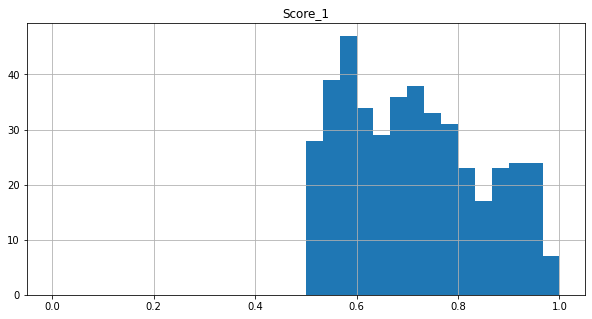

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

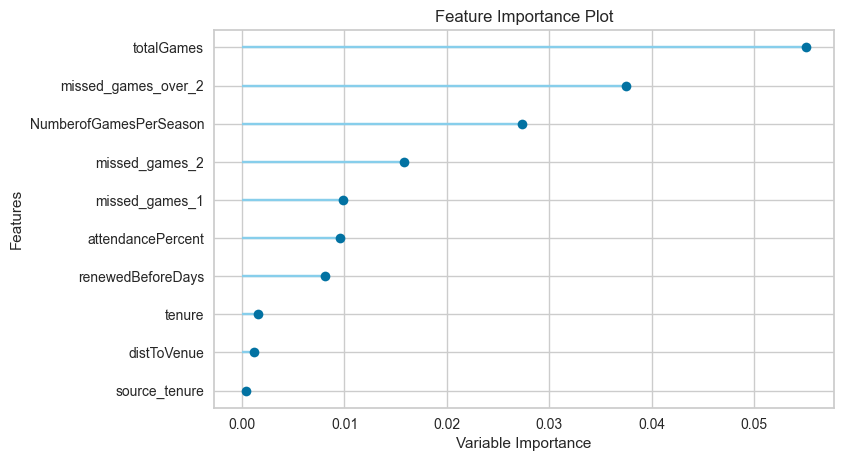

In [14]:
plot_model(best_model, plot='feature')

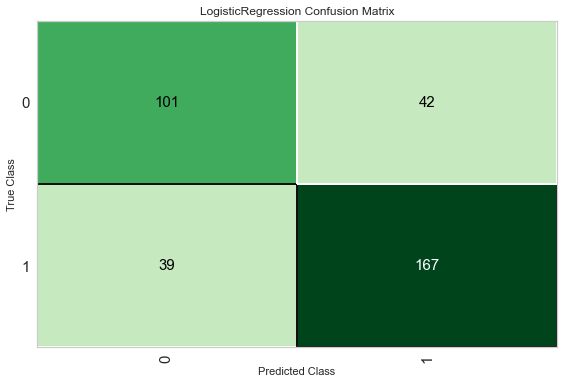

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?